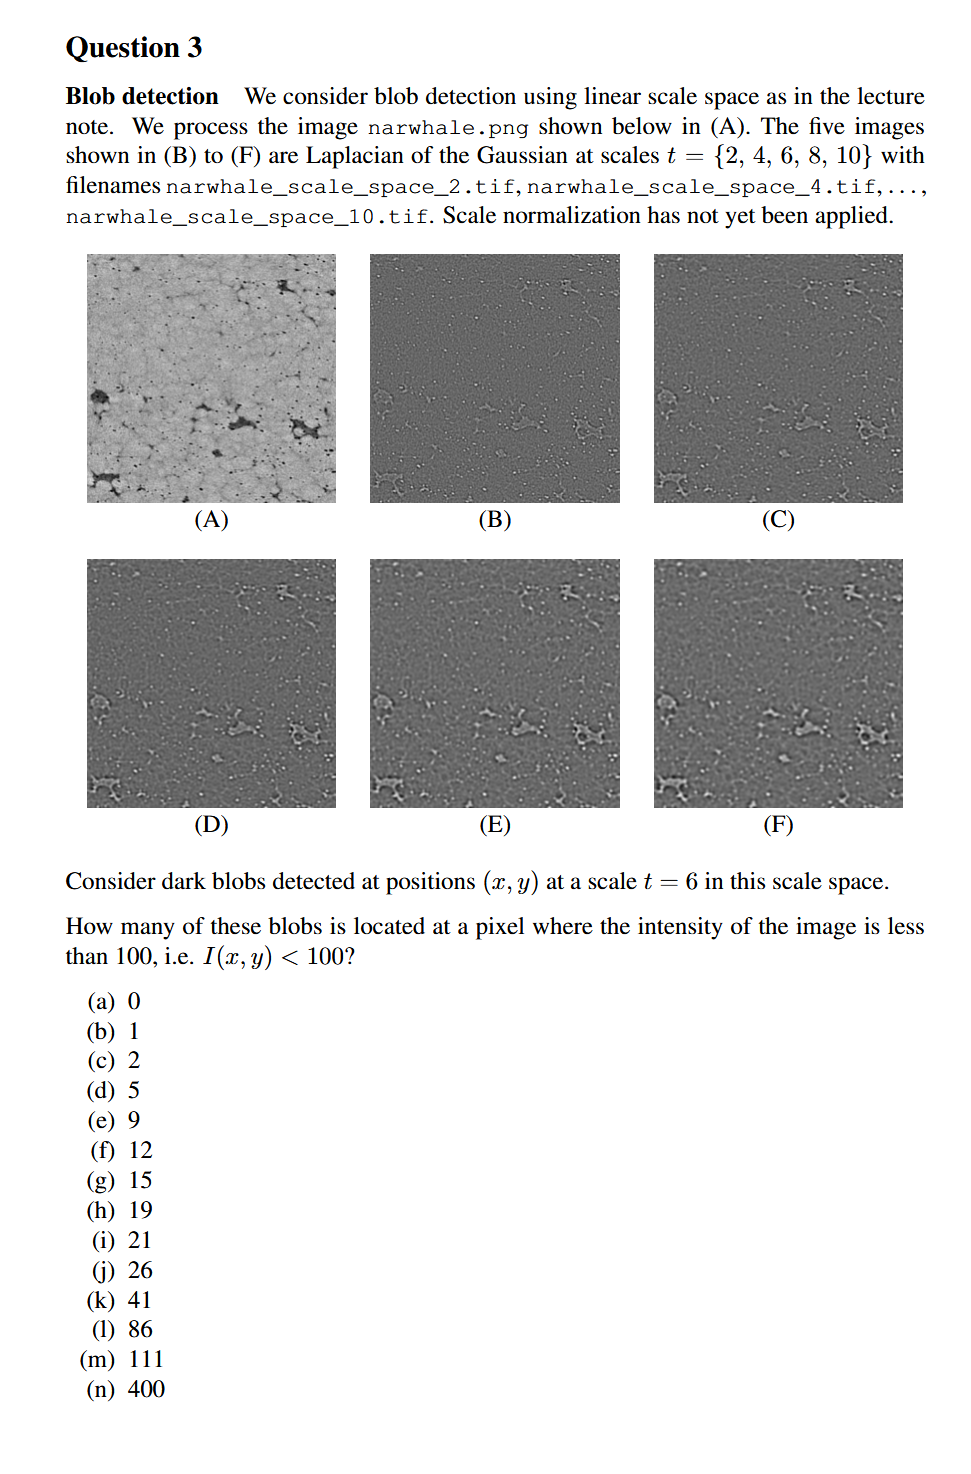

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.feature
import cv2



In [53]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
%pip install scipy
import numpy as np 
import matplotlib.pyplot as plt
import skimage
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter1d, gaussian_filter, gaussian_gradient_magnitude
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage.io import imread
im = io.imread('data/narwhale/narwhale_scale_space_6.tif', as_gray=True).astype(np.float64)




Note: you may need to restart the kernel to use updated packages.


DEMONSTRATION: CONFUSING vs TRANSPARENT BLOB DETECTION

Data summary:
  Image shape: (500, 500)
  Image intensity range: 0.0 to 222.0
  Dark pixels (< 100): 8804 out of 250000

--------------------------------------------------
Running EXACT original confusing code...
Original method found 21 blobs

--------------------------------------------------
Running transparent equivalent...
Made 26 comparisons per pixel (expected: 26)
Transparent method found 21 blobs

--------------------------------------------------
COMPARISON:
  Original method: 21 blobs at [(np.int64(10), np.int64(49)), (np.int64(72), np.int64(436)), (np.int64(74), np.int64(412)), (np.int64(115), np.int64(433)), (np.int64(129), np.int64(450)), (np.int64(274), np.int64(70)), (np.int64(276), np.int64(28)), (np.int64(297), np.int64(32)), (np.int64(311), np.int64(299)), (np.int64(329), np.int64(26)), (np.int64(346), np.int64(438)), (np.int64(347), np.int64(337)), (np.int64(354), np.int64(213)), (np.int64(369), np.int64(425)),

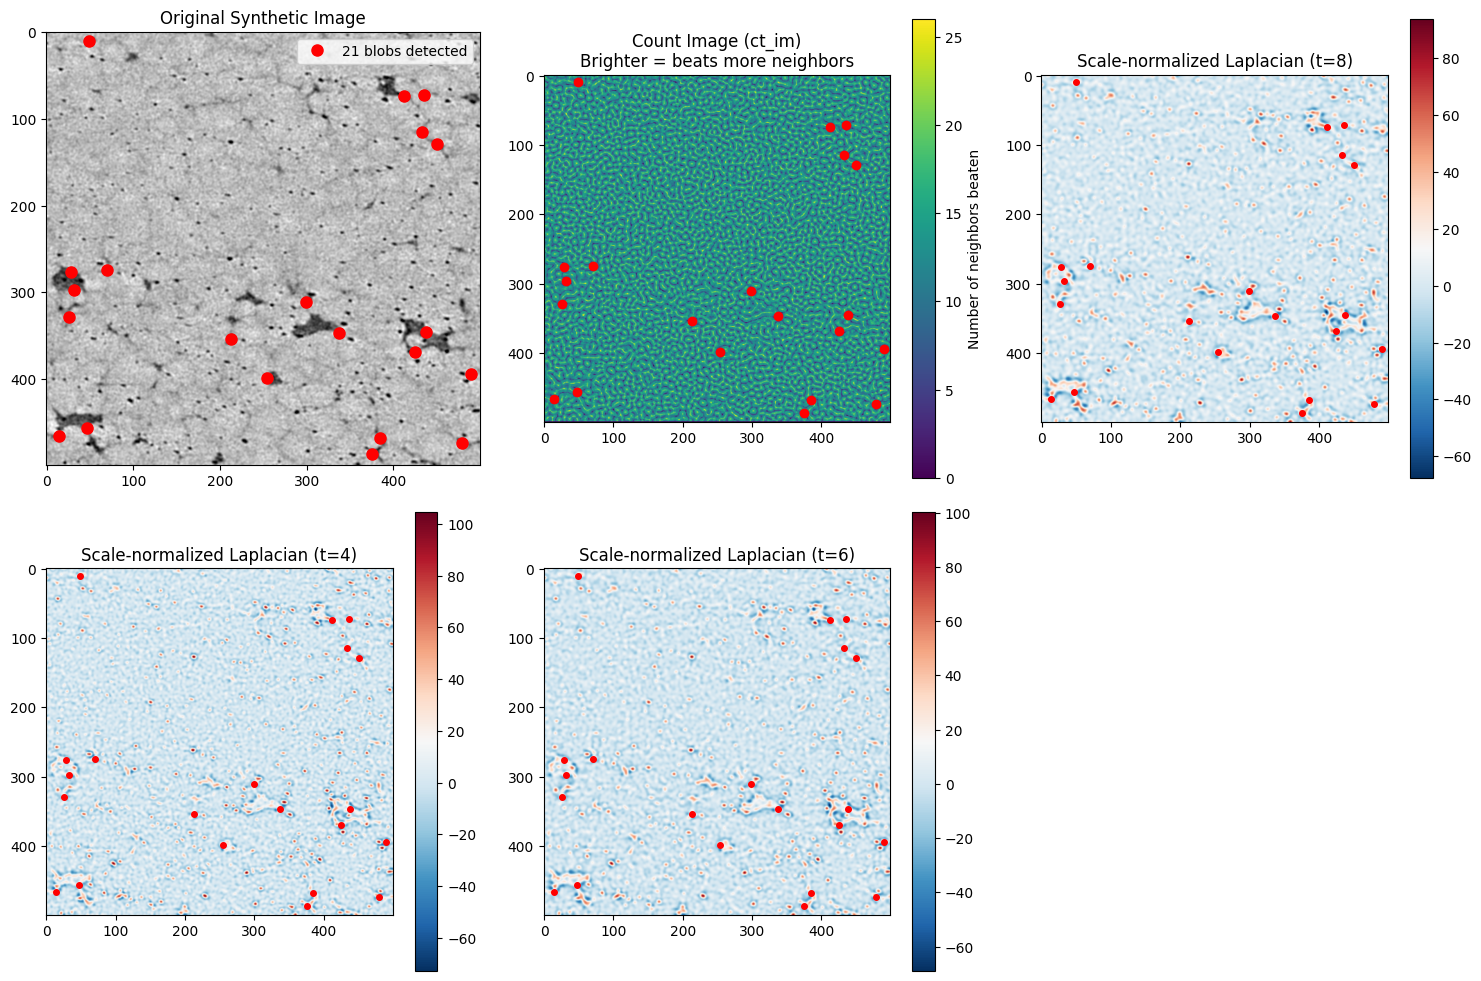


SUMMARY: Understanding the Original Confusing Code
The confusing code was checking if each pixel is a LOCAL MAXIMUM
in a 3×3×3 scale-space neighborhood (26 neighbors total).
ct_im==26 means 'this pixel beat ALL its neighbors'.
Combined with intensity < 100, this detects dark blob centers.
This is a fundamental technique in scale-space blob detection!


In [64]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.feature
import cv2

def getGaussDerivative(t):
    """
    Compute Gaussian kernel and its derivatives for scale parameter t
    """
    kSize = 5
    s = np.sqrt(t)  # standard deviation
    x = np.arange(int(-np.ceil(s * kSize)), int(np.ceil(s * kSize)) + 1)
    x = np.reshape(x, (-1, 1))  # reshape to column vector
    g = np.exp(-x**2 / (2 * t))  # Gaussian kernel
    g = g / np.sum(g)  # normalize to sum to 1
    dg = -x / t * g  # first derivative
    ddg = -g / t - x / t * dg  # second derivative
    dddg = -2 * dg / t - x / t * ddg  # third derivative
    return g, dg, ddg, dddg

def create_synthetic_narwhale_like_data():
    data_dir = 'data/'
    im = skimage.io.imread(data_dir + '/narwhale/narwhale.png')
    sc_vol = [
        4 * skimage.io.imread(data_dir + 'narwhale/narwhale_scale_space_4.tif'), 
        6 * skimage.io.imread(data_dir + 'narwhale/narwhale_scale_space_6.tif'),
        8 * skimage.io.imread(data_dir + 'narwhale/narwhale_scale_space_8.tif')
    ]
    
    return im, sc_vol

def original_confusing_code(sc_vol, im):
    """
    This is EXACTLY the original confusing code, unmodified
    """
    print("Running EXACT original confusing code...")
    
    ct_im = np.zeros(im.shape)
    for t in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            for k in [-1, 0, 1]:
                ct_im[1:-1, 1:-1] += (sc_vol[1][1:-1, 1:-1] > 
                        sc_vol[1+t][1+j:im.shape[0]-1+j, 1+k:im.shape[1]-1+k])
    
    r, c = np.where((ct_im==26) & (im < 100))
    
    print(f"Original method found {len(r)} blobs")
    return r, c, ct_im

def transparent_equivalent(sc_vol, im):
    """
    Transparent version that should give identical results
    """
    print("Running transparent equivalent...")
    
    rows, cols = im.shape
    ct_im = np.zeros((rows, cols))
    
    # The same triple loop, but explained step by step
    comparison_count = 0
    for t in [-1, 0, 1]:  # Scale offsets
        scale_idx = 1 + t  # Convert to array indices: 0, 1, 2
        
        for j in [-1, 0, 1]:  # Row offsets
            for k in [-1, 0, 1]:  # Column offsets
                
                # Skip center pixel (t=0, j=0, k=0)
                if t == 0 and j == 0 and k == 0:
                    continue
                
                comparison_count += 1
                
                # Extract the regions being compared
                center_region = sc_vol[1][1:-1, 1:-1]
                neighbor_region = sc_vol[scale_idx][1+j:rows-1+j, 1+k:cols-1+k]
                
                # Compare and add to count
                comparison_result = (center_region > neighbor_region)
                ct_im[1:-1, 1:-1] += comparison_result
    
    print(f"Made {comparison_count} comparisons per pixel (expected: 26)")
    
    # Find pixels with count 26 AND dark intensity
    r, c = np.where((ct_im == 26) & (im < 100))
    
    print(f"Transparent method found {len(r)} blobs")
    return r, c, ct_im

def individual_pixel_check(sc_vol, im, test_row=100, test_col=100):
    """
    Check one pixel manually to show the 26-neighbor comparison
    """
    print(f"\nDetailed check for pixel ({test_row}, {test_col}):")
    
    if im[test_row, test_col] >= 100:
        print(f"  Pixel intensity {im[test_row, test_col]:.1f} >= 100, too bright for dark blob")
        return False
    
    center_value = sc_vol[1][test_row, test_col]
    print(f"  Center value (scale 6): {center_value:.4f}")
    print(f"  Pixel intensity: {im[test_row, test_col]:.1f}")
    
    neighbor_count = 0
    print("  Checking 26 neighbors:")
    
    for t in [-1, 0, 1]:
        scale_idx = 1 + t
        scale_name = ['4', '6', '8'][scale_idx]
        
        for j in [-1, 0, 1]:
            for k in [-1, 0, 1]:
                if t == 0 and j == 0 and k == 0:
                    continue  # Skip center
                
                neighbor_row = test_row + j
                neighbor_col = test_col + k
                
                # Check bounds
                if (neighbor_row < 0 or neighbor_row >= im.shape[0] or 
                    neighbor_col < 0 or neighbor_col >= im.shape[1]):
                    continue
                
                neighbor_value = sc_vol[scale_idx][neighbor_row, neighbor_col]
                is_greater = center_value > neighbor_value
                
                if is_greater:
                    neighbor_count += 1
                
                print(f"    scale_{scale_name}[{neighbor_row},{neighbor_col}] = {neighbor_value:.4f}, center > neighbor: {is_greater}")
    
    print(f"  Result: center > {neighbor_count}/26 neighbors")
    
    if neighbor_count == 26:
        print(f"  ✅ LOCAL MAXIMUM! This pixel is a blob center.")
        return True
    else:
        print(f"  ❌ Not a local maximum.")
        return False

def demonstrate_and_compare():
    """
    Complete demonstration with comparison
    """
    print("="*70)
    print("DEMONSTRATION: CONFUSING vs TRANSPARENT BLOB DETECTION")
    print("="*70)
    
    # Create test data
    im, sc_vol = create_synthetic_narwhale_like_data()
    
    print(f"\nData summary:")
    print(f"  Image shape: {im.shape}")
    print(f"  Image intensity range: {im.min():.1f} to {im.max():.1f}")
    print(f"  Dark pixels (< 100): {np.sum(im < 100)} out of {im.size}")
    
    # Method 1: Original confusing code
    print(f"\n{'-'*50}")
    r1, c1, ct_im1 = original_confusing_code(sc_vol, im)
    
    # Method 2: Transparent equivalent
    print(f"\n{'-'*50}")
    r2, c2, ct_im2 = transparent_equivalent(sc_vol, im)
    
    # Compare results
    print(f"\n{'-'*50}")
    print("COMPARISON:")
    print(f"  Original method: {len(r1)} blobs at {list(zip(r1, c1))}")
    print(f"  Transparent method: {len(r2)} blobs at {list(zip(r2, c2))}")
    
    # Check if ct_im arrays are identical
    ct_diff = np.abs(ct_im1 - ct_im2).max()
    print(f"  Maximum difference in count images: {ct_diff}")
    
    if len(r1) == len(r2) and set(zip(r1, c1)) == set(zip(r2, c2)) and ct_diff < 1e-10:
        print("  ✅ PERFECT MATCH! Both methods are identical.")
    else:
        print("  ❌ Methods differ - debugging needed.")
    
    # Show detailed analysis for first detected blob (if any)
    if len(r1) > 0:
        print(f"\n{'-'*50}")
        individual_pixel_check(sc_vol, im, r1[0], c1[0])
    
    # Create visualization
    print(f"\n{'-'*50}")
    print("Creating visualization...")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Top row: Original image and detections
    axes[0,0].imshow(im, cmap='gray')
    axes[0,0].set_title('Original Synthetic Image')
    if len(r1) > 0:
        axes[0,0].plot(c1, r1, 'ro', markersize=8, label=f'{len(r1)} blobs detected')
        axes[0,0].legend()
    
    # Count image
    axes[0,1].imshow(ct_im1, cmap='viridis', vmin=0, vmax=26)
    axes[0,1].set_title('Count Image (ct_im)\nBrighter = beats more neighbors')
    if len(r1) > 0:
        axes[0,1].plot(c1, r1, 'ro', markersize=6)
    cbar = plt.colorbar(axes[0,1].images[0], ax=axes[0,1])
    cbar.set_label('Number of neighbors beaten')
    
    # Scale-space images
    for i, (scale_img, scale_val) in enumerate(zip(sc_vol, [4, 6, 8])):
        row = i // 3
        col = i if i < 3 else i - 3
        if i < 3:
            ax = axes[0, 2] if i == 2 else axes[1, i]
        else:
            ax = axes[1, col]
        
        im_plot = ax.imshow(scale_img, cmap='RdBu_r')
        ax.set_title(f'Scale-normalized Laplacian (t={scale_val})')
        if len(r1) > 0:
            ax.plot(c1, r1, 'ro', markersize=4)
        plt.colorbar(im_plot, ax=ax)
    
    # Remove unused subplot
    axes[1,2].remove()
    
    plt.tight_layout()
    plt.show()
    
    return im, sc_vol, r1, c1, ct_im1

if __name__ == "__main__":
    # Run the demonstration
    demonstrate_and_compare()
    
    print("\n" + "="*70)
    print("SUMMARY: Understanding the Original Confusing Code")
    print("="*70)
    print("The confusing code was checking if each pixel is a LOCAL MAXIMUM")
    print("in a 3×3×3 scale-space neighborhood (26 neighbors total).")
    print("ct_im==26 means 'this pixel beat ALL its neighbors'.")
    print("Combined with intensity < 100, this detects dark blob centers.")
    print("This is a fundamental technique in scale-space blob detection!")

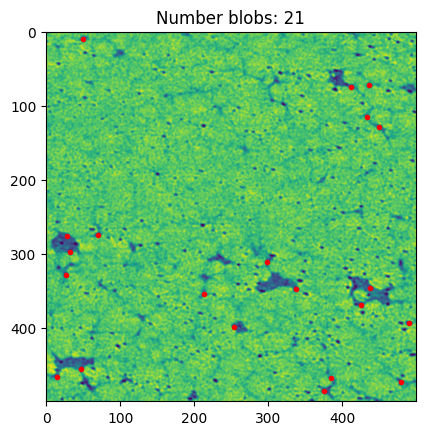

In [59]:
# QUESTION 3, Blob detection

data_dir = 'data/'


im = skimage.io.imread(data_dir + '/narwhale/narwhale.png')

# Multiply with t for scale normalization, only scales around 6 are of interest
sc_vol = [t * skimage.io.imread(data_dir + 
                f'narwhale/narwhale_scale_space_{t}.tif') for t in [4, 6, 8]] 

ct_im = np.zeros(im.shape)
for t in [-1, 0, 1]:
    for j in [-1, 0, 1]:
        for k in [-1, 0, 1]:
            ct_im[1:-1, 1:-1] += (sc_vol[1][1:-1, 1:-1] > 
                    sc_vol[1+t][1+j:im.shape[0]-1+j, 1+k:im.shape[1]-1+k])

r, c = np.where((ct_im==26) & (im < 100))  
plt.imshow(im)
plt.plot(c, r, 'r.')
plt.title(f'Number blobs: {len(r)}')
plt.show()